# Amazon Review - Helpful vs Not Helpful Reviews EDA

One idea for capstone project is to take the review body and determine if the review will be helpful. If we can deduce whether a review will be helpful or not, then Amazon can potentially automatically promote this review to the top of the list so users do not have to scroll through a bunch of reviews before reading an helpful review to save time.

A helpful review is defined as a review that has been voted by customers and 50% or more of the votes says it was helpful.


To save processing time, we will use our down-sampled file that has 100k reviews. This file is already pre-processed - ie, stripped out HTML tags, special characters, etc.



In this notebook, we will answer the following questions:

* How often do people actually vote on a review
* When people do vote, how do they generally vote - ie, helpful vs not helpful
* What are the characteristic of helpful reviews vs not helpful reviews - ie, word count, etc


# Summary of Results

* Around 13% of all reviews have votes
* When there are votes, people then to vote for helpful reviews vs not helpful reviews (65% vs 35%)
* Helpful reviews tend to be longer and varies in word count more than not helpful reviews
* Looking at ngram (min 1, max 3) along probably is not enough in determining whether a review is helpful or not since top occuring ngrams are similar between the two sets



In [1]:
# import sibling utilities
import sys
sys.path.append('../..')

import pandas as pd
from pandas import DataFrame
from pandas import Series
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
import logging

logging.basicConfig(level=logging.INFO)

import util.file_util as fu

import sys,os,os.path
DEBUG = bool(os.environ.get("IPYNB_DEBUG", False))

# global variables
COLUMNS_TO_DROP=["marketplace", "vine", "verified_purchase"]
USE_PANDAS=True
SEPERATOR=","

# data file directory
DATA_DIR = "../../dataset/amazon_reviews"

# full 9mil Wireless reviews - not enough memory locally to do this
ORIG_FILE_WIRELESS=f"{DATA_DIR}/amazon_reviews_us_Wireless_v1_00.tsv"
DATA_FILE_100k=f"{DATA_DIR}/amazon_reviews_us_Wireless_v1_00-100k-preprocessed.csv"

DATA_FILE=DATA_FILE_100k

## Read in our data file and drop any rows that have no review body

In [4]:
clean_df = pd.read_csv(DATA_FILE, sep=SEPERATOR, 
                         parse_dates=["review_date"])
# clean_df = reviews.dropna().drop(COLUMNS_TO_DROP, axis = 1)
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99567 entries, 0 to 99566
Data columns (total 6 columns):
star_rating        99567 non-null int64
helpful_votes      99567 non-null int64
total_votes        99567 non-null int64
review_headline    99567 non-null object
review_body        99567 non-null object
review_date        99567 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 4.6+ MB


# Adding some data

Before we do our analysis, we are going to create a couple columns that will help us do analysis later

* "has_votes" - this indicates whether the review has any votes at all
* "helpful_percentage" - if the review has votes, this will tell us out lf all votes how many of them said the review was helpful. This wlll be N/A if the review has not votes

In [5]:
votes = clean_df[["helpful_votes", "total_votes", "review_body", "star_rating"]].copy()

# add has_votes
votes["has_votes"] = votes.total_votes.apply(lambda x: True if x > 1 else False)
votes["helpful_percentage"] = votes.apply(lambda x: x.helpful_votes / x.total_votes if x.total_votes > 0 else np.nan, axis=1)

votes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99567 entries, 0 to 99566
Data columns (total 6 columns):
helpful_votes         99567 non-null int64
total_votes           99567 non-null int64
review_body           99567 non-null object
star_rating           99567 non-null int64
has_votes             99567 non-null bool
helpful_percentage    26498 non-null float64
dtypes: bool(1), float64(1), int64(3), object(1)
memory usage: 3.9+ MB


# Only 13% of our Reviews actually have votes

* Our original reviews have 9 million reviews. If we take only reviews that have votes, we will end up with 1.2 million in our corpus only

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


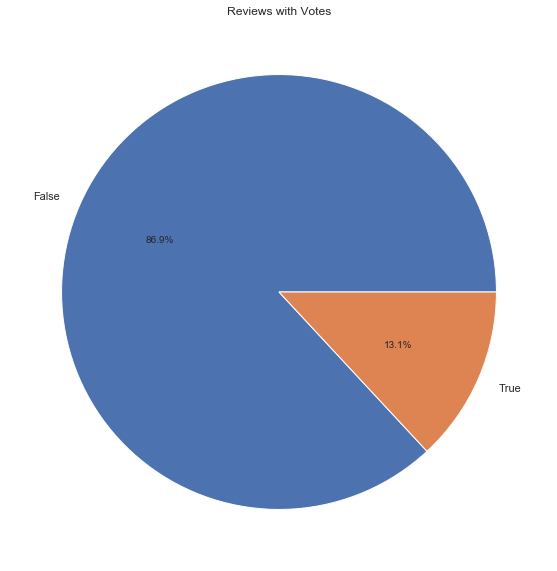

In [6]:
voted_grouped = votes[["has_votes", "total_votes"]].groupby("has_votes").count()
voted_grouped["voted_precentage"] = voted_grouped.total_votes / voted_grouped.total_votes.sum() * 100

_ = plt.figure(figsize=(10, 10))
_ = plt.title("Reviews with Votes")
_ = plt.pie(voted_grouped.voted_precentage, labels=voted_grouped.index, autopct='%1.1f%%')


# People tend to vote for helpful reviews more often than not helpful reviews

* Around 35% of reviews were voted as not helpful - ie, less than 50% vote saying it was helpful

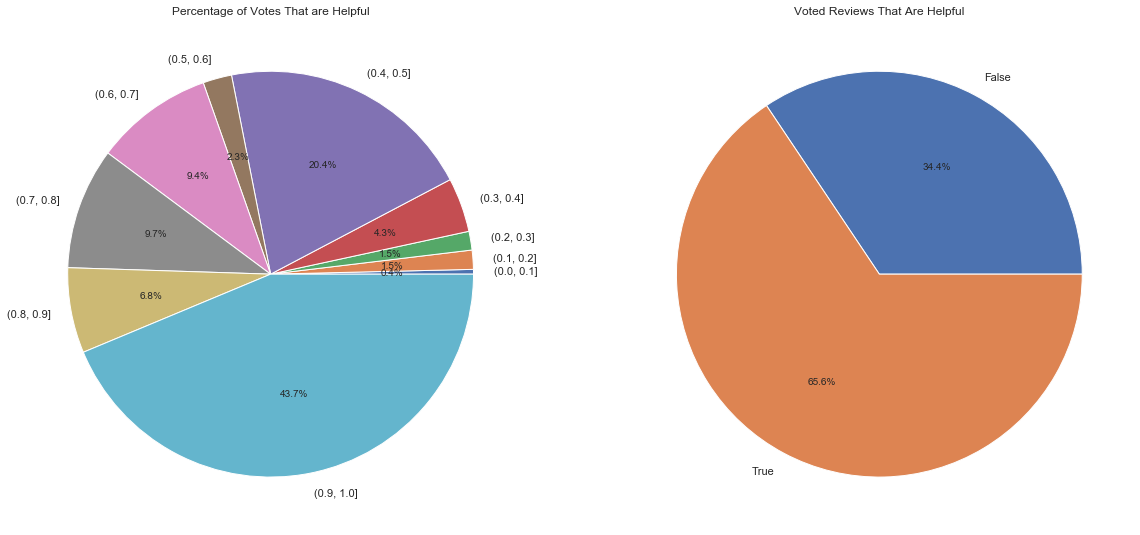

In [7]:
has_votes = votes[votes.has_votes == True].copy()

bins = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

has_votes["percentage_bin"] = pd.cut(has_votes.helpful_percentage, bins)
# has_votes.groupby("percentage_bin").count()

helpful_votes = has_votes.groupby("percentage_bin").count().reset_index()

f, a = plt.subplots(1, 2, figsize=(20, 10))
# _ = plt.figure(figsize=(10, 10))
_ = a[0].set_title("Percentage of Votes That are Helpful")
_ = a[0].pie(helpful_votes.helpful_percentage, labels=helpful_votes.percentage_bin, autopct='%1.1f%%')



has_votes["helpful_review"] = has_votes.helpful_percentage.apply(lambda x: True if x > 0.5 else False)
helpful_not_helpful = has_votes.groupby("helpful_review").count().reset_index()


# _ = plt.figure(figsize=(10, 10))
_ = a[1].set_title("Voted Reviews That Are Helpful")
_ = a[1].pie(helpful_not_helpful.helpful_percentage, labels=helpful_not_helpful.helpful_review, autopct='%1.1f%%')

# Compare Helpful Reviews vs Not Helpful Reviews


### Examples of Helpful Reviews

In [8]:
pd.set_option('max_colwidth', 100)

has_votes["review_wc"] = has_votes.review_body.apply(lambda x: len(x.split(" ")))

helpful_reviews = has_votes[has_votes.helpful_review == True]
helpful_reviews.sample(10).review_body

42533    ipod screen exact fit ordered watched video youtube replaced screen without problem easy do new ...
11858    seems work well one button very confusing unit seems like go series click make charge phone user...
99389    display quit working first day unit replaced display went second unit hour finally second unit q...
12713    doe job needed hang ipod touch wall however need plugged headphone jack wall case doe not allow ...
62340    purchased cable replace previous one used connect iphone car audio system cable short retraction...
3658     very easy apply watch short video instruction take ti ame aligning protector peeling backing smo...
82199    love case super cute girly doe not like polka dot fit perfect iphone 5 nice keep phone sli doe n...
26045                                    came nicely packaged new screen charger felt like getting new phone
3786                                    stopped working couple week light use also say not compatible iphone
83385    great pouc

### Examples of not helpful reviews

In [9]:
not_helpful_reviews = has_votes[has_votes.helpful_review == False]
not_helpful_reviews.sample(10)["review_body"]

18829    listed number one seller need something help organize small electronics very small not lot room ...
62948                                  charge iphone full battery iphone started 2 not recommend iphone user
57858    although like phone got purchased unlocked advertised received unlocked amazon stepped did adjus...
93214    smart phone wonderful need use lot drain battery pretty quickly found carrying spare battery who...
1738                                                                                                    love
40568                                                                       samsung note 3 glass replacement
44798    silicon plastic case protect phone very well dropped phone several ti ames no break crack screen...
71028    item looking arrived ti amely fashion would given 5 star however one tiny flaw arrived small por...
23107    used live london american student whose fafsa money went far tried cut cost walking commute when...
34364    course dai

### Compare Word Length of Helpful vs Not Helpful Reviews

* Minimum word count is the same for both
* helpful reviews vary more in terms of word count length as the standard deviation is twice as big as not helpful reviews
* Helpful reviews then to be longer
    * mean word count for helpful reviews is almost double the mean of not helpful reviews
    * the max length of a helpful review is also much longer than a not helpful review
    * lenght of review body for all quantiles are also longer for helpful vs not helpful reviews

In [10]:
helpful_reviews.review_wc.describe()

count    8548.000000
mean       66.729410
std       109.210453
min         1.000000
25%        18.000000
50%        37.000000
75%        75.000000
max      4686.000000
Name: review_wc, dtype: float64

In [11]:
not_helpful_reviews.review_wc.describe()

count    4480.000000
mean       36.189955
std        50.077474
min         1.000000
25%        12.000000
50%        21.000000
75%        43.000000
max       890.000000
Name: review_wc, dtype: float64

# Common Words/Phrases in Helpful and Not Helpful Reviews

We will use a mix of uni-gram, bi gram and tri-grams for this with maximum of 4000 features - this was the optimal configuration from our previous EDA notebooks

* doesn't look like we can discern a helpful vs not helpful reviews by ngram occurence alone as the two lists are very similar

Common ngrams in Helpful Reviews

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

cv_helpful = CountVectorizer(ngram_range=(1,3), max_features=4000)
X_helpful = cv_helpful.fit_transform(helpful_reviews["review_body"].array)


# sum up each columns to get number of occurence for our corpus for each ngram
ngram_count_helpful = pd.DataFrame(np.transpose(np.sum(X_helpful, axis=0))).rename({0: "ngram_occurence"}, axis=1)

# sort list with most frequent ngrams at the top
top_helpful = ngram_count_helpful.sort_values("ngram_occurence", ascending=False)
np.take(cv_helpful.get_feature_names(), top_helpful.head(30).index.tolist())

array(['not', 'phone', 'case', 'one', 'will', 'very', 'would', 'do',
       'like', 'work', 'use', 'great', 'screen', 'get', 'ti', 'no', 'doe',
       'good', 'battery', 'ame', 'well', 'do not', 'product', 'ti ame',
       'also', 'did', 'fit', 'doe not', 'really', 'even'], dtype='<U26')

Common ngrams in not helpful reviews

In [23]:
cv_not_helpful = CountVectorizer(ngram_range=(1,3), max_features=4000)
X_not_helpful = cv_not_helpful.fit_transform(not_helpful_reviews["review_body"].array)


# sum up each columns to get number of occurence for our corpus for each ngram
ngram_count_not_helpful = pd.DataFrame(np.transpose(np.sum(X_not_helpful, axis=0))).rename({0: "ngram_occurence"}, axis=1)

# sort list with most frequent ngrams at the top
top_not_helpful = ngram_count_not_helpful.sort_values("ngram_occurence", ascending=False)
np.take(cv_not_helpful.get_feature_names(), top_not_helpful.head(30).index.tolist())

array(['not', 'phone', 'case', 'one', 'would', 'will', 'do', 'very',
       'work', 'product', 'good', 'like', 'get', 'great', 'ti', 'screen',
       'use', 'no', 'doe', 'did', 'do not', 'ame', 'battery', 'ti ame',
       'doe not', 'fit', 'well', 'iphone', 'back', 'did not'],
      dtype='<U24')